## Definitions

In [52]:

input_data_type = 'lemmatize_nostopwords'
file_date = '2022-11-28_19-41-48'
train_path = f'../results/bertopic/bertopic_{input_data_type}_data_{file_date}_train.csv'
test_path = f'../results/bertopic/bertopic_{input_data_type}_data_{file_date}_test.csv'

results_folder = '../results/bertopic_ncbo/'

In [53]:
UMLS_ST21pv_ontologies_ids = ['CPT', 'FMA', 'GO', 'HGNC', 'HPO', 'ICD10', 'ICD10CM', 'ICD9CM', 'MDR', 'MSH', 'MTH', 'NCBI', 'NCI', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNOMEDCT_US']

# HPO = HP
# MDR = MEDDRA
# MSH = MESH
# MTH = ?
# NCBI = NCBITAXON
# NCI = NCIT
# SNOMEDCT_US = SNMI
UMLS_NCBO_ST21pv_ontologies_ids = ['CPT', 'FMA', 'GO', 'HGNC', 'HP', 'ICD10', 'ICD10CM', 'ICD9CM', 'MEDDRA', 'MESH', 'NCBITAXON', 'NCIT', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNMI']


UMLS_ST21pv_semantic_types_ids = ['T005', 'T007', 'T017', 'T022', 'T031', 'T033', 'T037', 'T038',
'T058', 'T062', 'T074', 'T082', 'T091', 'T092', 'T097', 'T098', 'T103', 'T168', 'T170', 'T201', 'T204']

## Read the data to annotate

In [54]:
def transform_strings_to_arrays(df, col_names = ['tokenized_sentences', 'tokenized_words', 'tokenized_words_processed', 'tokenized_words_no_stopwords']):
    for col in col_names:
        df[col] = df[col].apply(eval)
    return df

In [55]:
import datetime
def get_now_str():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [56]:
import pandas as pd
import re

def read_berttopic_results(path):
    data = pd.read_csv(path, index_col=0)
    data = transform_strings_to_arrays(data, col_names = ['topic_keywords'])
    data['text_to_annotate'] = data.topic_keywords.apply(
        lambda row: re.sub(r"[\'\[\]]", "", str([keyword[0] for keyword in row]))
        )
        
    return data

In [57]:
train_data = read_berttopic_results(train_path)
test_data = read_berttopic_results(test_path)

In [58]:
train_data

,PMID,topic_number,topic_probs,topic_keywords,text_to_annotate
0,25763772,-1,0.000000,"[(patient, 0.010129049120405477), (study, 0.00...","patient, study, cell, effect, analysis, group,..."
1,25847295,-1,0.000000,"[(patient, 0.010129049120405477), (study, 0.00...","patient, study, cell, effect, analysis, group,..."
2,26316050,4,1.000000,"[(nanoparticles, 0.02489330206742853), (surfac...","nanoparticles, surface, bone, cell, coating, r..."
3,26406200,22,0.712748,"[(pain, 0.07015457998097199), (spinal, 0.03453...","pain, spinal, surgery, fusion, lumbar, patient..."
4,26424709,1,0.815083,"[(health, 0.0328786132052834), (service, 0.018...","health, service, student, intervention, medica..."
...,...,...,...,...,...
3508,28549399,-1,0.000000,"[(patient, 0.010129049120405477), (study, 0.00...","patient, study, cell, effect, analysis, group,..."
3509,28549760,5,1.000000,"[(diabetes, 0.03293764754273004), (obesity, 0....","diabetes, obesity, bmi, intake, body, associat..."
3510,28550154,33,1.000000,"[(electrode, 0.06876839158616202), (detection,...","electrode, detection, ecl, ncs, cds, electroch..."
3511,28550348,42,1.000000,"[(medication, 0.08525438163379365), (medicine,...","medication, medicine, asthma, migraine, cost, ..."


## NCBO tagger API connection

In [59]:
import urllib.request, urllib.error, urllib.parse
import json
import os
from pprint import pprint

REST_URL = "http://data.bioontology.org"
API_KEY = "194c9635-ce67-4e70-81c5-898c3a2b30fb"

def get_json(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())

def print_annotations(annotations, get_class=True):
    for result in annotations:
        class_details = result["annotatedClass"]
        if get_class:
            try:
                class_details = get_json(result["annotatedClass"]["links"]["self"])
            except urllib.error.HTTPError:
                print(f"Error retrieving {result['annotatedClass']['@id']}")
                continue
        print("Class details")
        print("\tid: " + class_details["@id"])
        print("\tprefLabel: " + class_details["prefLabel"])
        print("\tontology: " + class_details["links"]["ontology"])

        print("Annotation details")
        for annotation in result["annotations"]:
            print("\tfrom: " + str(annotation["from"]))
            print("\tto: " + str(annotation["to"]))
            print("\tmatch type: " + annotation["matchType"])

        if result["hierarchy"]:
            print("\n\tHierarchy annotations")
            for annotation in result["hierarchy"]:
                try:
                    class_details = get_json(annotation["annotatedClass"]["links"]["self"])
                except urllib.error.HTTPError:
                    print(f"Error retrieving {annotation['annotatedClass']['@id']}")
                    continue
                pref_label = class_details["prefLabel"] or "no label"
                print("\t\tClass details")
                print("\t\t\tid: " + class_details["@id"])
                print("\t\t\tprefLabel: " + class_details["prefLabel"])
                print("\t\t\tontology: " + class_details["links"]["ontology"])
                print("\t\t\tdistance from originally annotated class: " + str(annotation["distance"]))

        print("\n\n")

## Annotations within 17 available (out of 18 all) ontologies from ULMS used in MedMentions

In [60]:
train_data['ncbo_annotations'] = train_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&text=" + urllib.parse.quote(text)))

KeyboardInterrupt: 

In [ ]:
test_data['ncbo_annotations'] = test_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&text=" + urllib.parse.quote(text)))

## Annotations within 17 available (out of 18 all) ontologies from ULMS used in MedMentions, but only for sematic types included in ST21pv

In [ ]:
train_data['ncbo_annotations_ST21pv_semtypes'] = train_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&semantic_types={','.join(UMLS_ST21pv_semantic_types_ids)}&text=" + urllib.parse.quote(text)))

In [ ]:
test_data['ncbo_annotations_ST21pv_semtypes'] = test_data.text_to_annotate.apply(lambda text:  get_json(REST_URL + f"/annotator?ontologies={','.join(UMLS_NCBO_ST21pv_ontologies_ids)}&semantic_types={','.join(UMLS_ST21pv_semantic_types_ids)}&text=" + urllib.parse.quote(text)))

## Save resultss

In [ ]:
now = get_now_str()

save_train_name = f'bertopic_ncbo_{input_data_type}_data_{now}_train.csv'
save_test_name = f'bertopic_ncbo_{input_data_type}_data_{now}_test.csv'

save_train_path = os.path.join(results_folder, save_train_name)
save_test_path = os.path.join(results_folder, save_test_name)

In [ ]:
to_save_test_data = test_data[['PMID', 'text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]
to_save_train_data = train_data[['PMID', 'text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]

In [ ]:
to_save_train_data.to_csv(save_train_path)
to_save_test_data.to_csv(save_test_path)

## Results analysis

In [ ]:
train_number_of_ncbo_annotations = train_data['ncbo_annotations'].apply(len)
test_number_of_ncbo_annotations = test_data['ncbo_annotations'].apply(len)
train_number_of_ncbo_annotations_ST21pv_semtypes = train_data['ncbo_annotations_ST21pv_semtypes'].apply(len)
test_number_of_ncbo_annotations_ST21pv_semtypes = test_data['ncbo_annotations_ST21pv_semtypes'].apply(len)

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(ax, data, xlab, ylab, title, bins = 10):
    ax.hist(data, bins = bins)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    pass

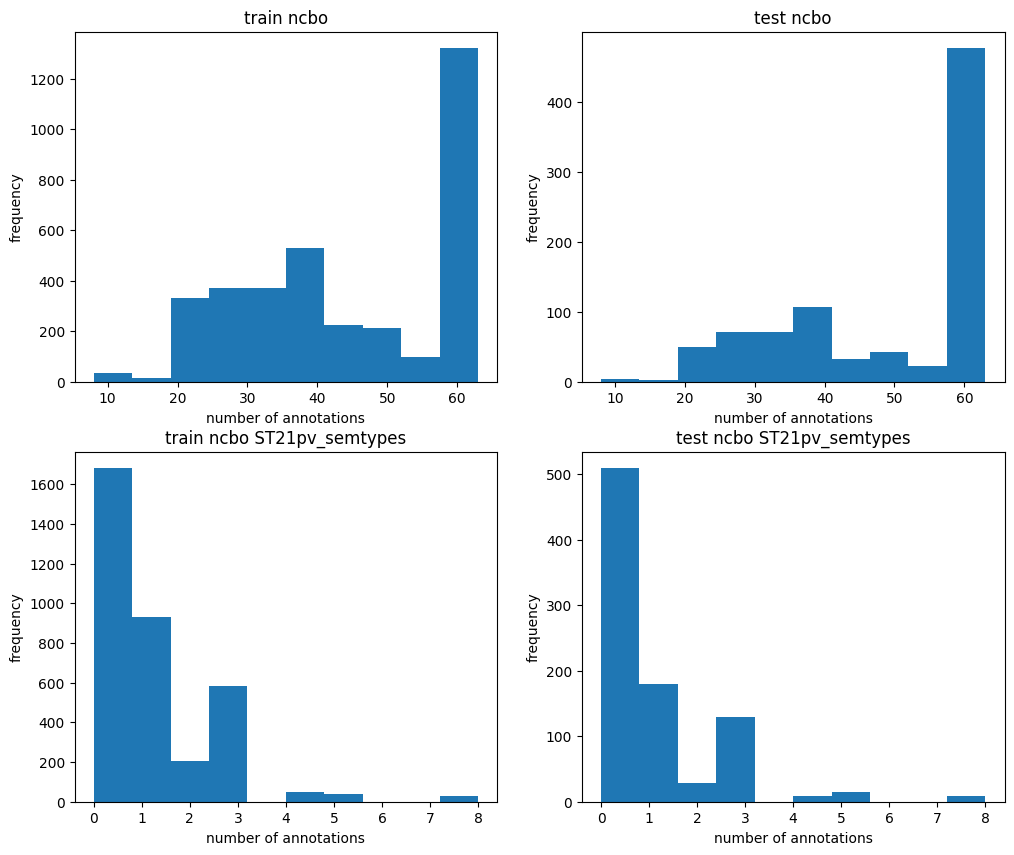

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12, 10))

ax = axes[0,0]
plot_hist(axes[0,0], train_number_of_ncbo_annotations, "number of annotations", "frequency", "train ncbo")
plot_hist(axes[0,1], test_number_of_ncbo_annotations, "number of annotations", "frequency", "test ncbo")
plot_hist(axes[1,0], train_number_of_ncbo_annotations_ST21pv_semtypes, "number of annotations", "frequency", "train ncbo ST21pv_semtypes")
plot_hist(axes[1,1], test_number_of_ncbo_annotations_ST21pv_semtypes, "number of annotations", "frequency", "test ncbo ST21pv_semtypes")


## Extracting first order keywords-anotations matching

In [64]:
train_data = pd.read_csv(f'../results/bertopic_ncbo/bertopic_ncbo_lemmatize_nostopwords_data_2022-11-28_22-55-33_train.csv', index_col=0)
test_data = pd.read_csv( f'../results/bertopic_ncbo/bertopic_ncbo_lemmatize_nostopwords_data_2022-11-28_22-55-33_test.csv', index_col=0)

In [ ]:
train_data_to_annotate = train_data[['text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]
train_data_to_annotate = train_data_to_annotate.drop_duplicates()

test_data_to_annotate = test_data[['text_to_annotate', 'ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes']]
test_data_to_annotate = test_data_to_annotate.drop_duplicates()

In [ ]:
data_to_annotate = pd.concat([train_data_to_annotate, test_data_to_annotate], axis=0)
data_to_annotate = data_to_annotate.drop_duplicates()
data_to_annotate = transform_strings_to_arrays(data_to_annotate, col_names=['ncbo_annotations', 'ncbo_annotations_ST21pv_semtypes'])

In [ ]:
data_to_annotate.iloc[0]['ncbo_annotations']

[{'annotatedClass': {'@id': 'http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#C53691',
   '@type': 'http://www.w3.org/2002/07/owl#Class',
   'links': {'self': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691',
    'ontology': 'https://data.bioontology.org/ontologies/NCIT',
    'children': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691/children',
    'parents': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691/parents',
    'descendants': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691/descendants',
    'ancestors': 'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C53691/ancestors',
    'instances': 'h

In [ ]:
def create_annotation_pairs(sample_row, column_name):
    found_concepts = sample_row[column_name]
    res_ann_pairs= []
    for _, concept in enumerate(found_concepts):
        max_trials = 5
        trials_no = 0
        while trials_no < max_trials:
            try:
                concept_class = get_json(concept["annotatedClass"]["links"]["self"])
                concept_class_ancestors = get_json(concept["annotatedClass"]['links']['ancestors'])
                break
            except:
                trials_no+=1
                continue
        if trials_no==max_trials:
            raise Exception("number of unsuccessfull connection attempts is max_trials")

        annotations = concept['annotations']

        # annotations for this class
        for annot in annotations:
            res_ann_pairs.append([annot['text'], concept_class["prefLabel"], 'DIRECT', concept["annotatedClass"]["links"]["self"]])

        # annotations for ancestors
        for annot in annotations:
            for ancestor in concept_class_ancestors:
                res_ann_pairs.append([annot['text'], ancestor["prefLabel"], 'ANCESTOR', concept["annotatedClass"]['links']['ancestors']])
      
    unique_ann_pairs = [list(x) for x in set(tuple(x) for x in res_ann_pairs)]
    return unique_ann_pairs
        

In [ ]:
data_to_annotate['ncbo_annotation_pairs'] = data_to_annotate.apply(create_annotation_pairs, column_name='ncbo_annotations', axis = 1)

In [ ]:
data_to_annotate['ncbo_annotation_ST21pv_semtypes_pairs'] = data_to_annotate.apply(create_annotation_pairs, column_name='ncbo_annotations_ST21pv_semtypes', axis = 1)

### Annotation pairs example

In [ ]:
data_to_annotate['ncbo_annotation_pairs'].iloc[0]

[['CELL',
  'Diagnostic, Therapeutic, or Research Equipment',
  'ANCESTOR',
  'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C49867/ancestors'],
 ['GROUP',
  'Conceptual Entity',
  'ANCESTOR',
  'https://data.bioontology.org/ontologies/ICD10/classes/http%3A%2F%2Fpurl.bioontology.org%2Fontology%2FSTY%2FT096/ancestors'],
 ['LEVEL',
  'Geographic Area',
  'ANCESTOR',
  'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C87192/ancestors'],
 ['CELL',
  'Anatomical Structure',
  'ANCESTOR',
  'https://data.bioontology.org/ontologies/MESH/classes/http%3A%2F%2Fpurl.bioontology.org%2Fontology%2FSTY%2FT025/ancestors'],
 ['CELL',
  'Manufactured Object',
  'ANCESTOR',
  'https://data.bioontology.org/ontologies/NCIT/classes/http%3A%2F%2Fncicb.nci.nih.gov%2Fxml%2Fowl%2FEVS%2FThesaurus.owl%23C60787/ancestors'],
 ['PATIENT',
  'Veterinary Patient',
  'DIRECT'

In [ ]:
data_to_annotate[['text_to_annotate', 'ncbo_annotation_pairs']].to_dict()

## Save annotated pairs

In [65]:
text_to_annot_ncbo_pairs = dict(zip(data_to_annotate.text_to_annotate, data_to_annotate.ncbo_annotation_pairs))
text_to_annot_ncboST21pv_semtypes_pairs = dict(zip(data_to_annotate.text_to_annotate, data_to_annotate.ncbo_annotation_ST21pv_semtypes_pairs))

In [66]:
train_data['ncbo_annotations_pairs'] = train_data['text_to_annotate'].apply(lambda text: text_to_annot_ncbo_pairs[text])
train_data['ncbo_annotations_ST21pv_semtypes_pairs'] = train_data['text_to_annotate'].apply(lambda text: text_to_annot_ncboST21pv_semtypes_pairs[text])

test_data['ncbo_annotations_pairs'] = test_data['text_to_annotate'].apply(lambda text: text_to_annot_ncbo_pairs[text])
test_data['ncbo_annotations_ST21pv_semtypes_pairs'] = test_data['text_to_annotate'].apply(lambda text: text_to_annot_ncboST21pv_semtypes_pairs[text])

In [68]:
test_data

,PMID,text_to_annotate,ncbo_annotations,ncbo_annotations_ST21pv_semtypes,ncbo_annotations_pairs,ncbo_annotations_ST21pv_semtypes_pairs
0,26868132,"diabetes, obesity, bmi, intake, body, associat...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[FOOD, Physical Object, ANCESTOR, https://dat...","[[OBESITY, OBESITY, DIRECT, https://data.bioon..."
1,27059693,"patient, study, cell, effect, analysis, group,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CELL, Diagnostic, Therapeutic, or Research E...",[]
2,27061776,"patient, study, cell, effect, analysis, group,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CELL, Diagnostic, Therapeutic, or Research E...",[]
3,27172917,"thyroid, 95, tc, cancer, patient, radiotherapy...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[GEC, Clinical Pathology Procedure, ANCESTOR,...","[[CANCER, Pleocyemata, ANCESTOR, https://data...."
4,27213687,"eye, thickness, macular, glaucoma, retinal, ch...",[{'annotatedClass': {'@id': 'http://purl.org/s...,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[GLAUCOMA, Abnormality of the eye, ANCESTOR, ...","[[GLAUCOMA, Oligohymenophorea, ANCESTOR, https..."
...,...,...,...,...,...,...
874,28548970,"patient, study, cell, effect, analysis, group,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CELL, Diagnostic, Therapeutic, or Research E...",[]
875,28549352,"brain, movement, connectivity, memory, stimula...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[BRAIN, Anatomic Structure, System, or Substa...",[]
876,28549770,"patient, study, cell, effect, analysis, group,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CELL, Diagnostic, Therapeutic, or Research E...",[]
877,28550165,"patient, study, cell, effect, analysis, group,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CELL, Diagnostic, Therapeutic, or Research E...",[]


In [69]:
train_data

,PMID,text_to_annotate,ncbo_annotations,ncbo_annotations_ST21pv_semtypes,ncbo_annotations_pairs,ncbo_annotations_ST21pv_semtypes_pairs
0,25763772,"patient, study, cell, effect, analysis, group,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CELL, Diagnostic, Therapeutic, or Research E...",[]
1,25847295,"patient, study, cell, effect, analysis, group,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CELL, Diagnostic, Therapeutic, or Research E...",[]
2,26316050,"nanoparticles, surface, bone, cell, coating, r...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[CELL, Diagnostic, Therapeutic, or Research E...","[[SURFACE, Surface, DIRECT, https://data.bioon..."
3,26406200,"pain, spinal, surgery, fusion, lumbar, patient...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[SPINE, Anatomical entity, ANCESTOR, https://...","[[POSTERIOR, Posterior, DIRECT, https://data.b..."
4,26424709,"health, service, student, intervention, medica...",[{'annotatedClass': {'@id': 'http://purl.bioon...,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[PATIENT, Veterinary Patient, DIRECT, https:/...","[[DATA, Data, DIRECT, https://data.bioontology..."
...,...,...,...,...,...,...
3508,28549399,"patient, study, cell, effect, analysis, group,...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[CELL, Diagnostic, Therapeutic, or Research E...",[]
3509,28549760,"diabetes, obesity, bmi, intake, body, associat...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[FOOD, Physical Object, ANCESTOR, https://dat...","[[OBESITY, OBESITY, DIRECT, https://data.bioon..."
3510,28550154,"electrode, detection, ecl, ncs, cds, electroch...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[],"[[ECL, Clinical Pathology Procedure, ANCESTOR,...",[]
3511,28550348,"medication, medicine, asthma, migraine, cost, ...",[{'annotatedClass': {'@id': 'http://ncicb.nci....,[{'annotatedClass': {'@id': 'http://purl.bioon...,"[[ASTHMA, Asthma Pathway, DIRECT, https://data...","[[MEDICINE, Medicine, DIRECT, https://data.bio..."


In [70]:
now = get_now_str()

save_train_name = f'bertopic_ncbo_fulldata_{input_data_type}_data_{now}_train.csv'
save_test_name = f'bertopic_ncbo__fulldata_{input_data_type}_data_{now}_test.csv'

save_train_path = os.path.join(results_folder, save_train_name)
save_test_path = os.path.join(results_folder, save_test_name)

In [72]:
train_data.to_csv(save_train_path, index=False)
test_data.to_csv(save_test_path, index=False)